In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import glob
import toml

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
import ray
ray.init()

2023-04-17 10:37:54,728	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.9.6
Ray version:,2.0.1


In [46]:
rootdir = "/Users/akshay/research/burrito"
outdirs = ["kv-shenango_rt-mlx5-edbd777", "kv-shenango_channel-mlx5-edbd777"]

In [47]:
def read_toml(cfg):
    return toml.load(cfg)['exp']

def merge_tomls(cfgs):
    merged_cfg = {}
    for cfg in cfgs:
        for key in cfg:
            if key in merged_cfg:
                if type(cfg[key]) != type(merged_cfg[key]):
                    raise Exception(f"mismatched config types: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == int and merged_cfg[key] != cfg[key]:
                    raise Exception(f"int-valued configs must match: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == list:
                    merged_cfg[key] = list(set(cfg[key]).union(set(merged_cfg[key])))
            else:
                merged_cfg[key] = cfg[key]
    return merged_cfg

tomls = {}
for outdir in outdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    tomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

tomls

{'kv-shenango_rt-mlx5-edbd777': {'wrk': ['./kvstore-ycsb/ycsbc-mock/workloadb-8.access'],
  'datapath': ['shenango_channel', 'shenangort'],
  'load': [40000,
   80000,
   100000,
   120000,
   160000,
   200000,
   240000,
   320000,
   400000],
  'poisson-arrivals': [True],
  'shardtype': ['client'],
  'shards': [8],
  'no-chunnels': [False, True]},
 'kv-shenango_channel-mlx5-edbd777': {'wrk': ['./kvstore-ycsb/ycsbc-mock/workloadb-8.access'],
  'datapath': ['shenango_channel'],
  'load': [10000,
   20000,
   40000,
   60000,
   80000,
   100000,
   120000,
   140000,
   160000,
   180000,
   200000],
  'poisson-arrivals': [True],
  'shardtype': ['client'],
  'shards': [8],
  'no-chunnels': [True, False]}}

In [48]:
# note: this aggregates requestclients together

def clean(flds):
    if len(flds) == 5:
        print(f'warning: dropping flds[1]: {flds}')
        return [flds[0], flds[2], flds[3], flds[4]]
    else:
        print(f"bad line in data: {flds}")
        return None

@ray.remote
def read_exp(outdir, dp, ns, st, o, p, c, iter_num):
    def get_clients():
        fn_wildcard = f"{rootdir}/{outdir}/{dp}-{ns}-{st}shard-{o}-poisson={p}-{c}-{iter_num}-client-*.data"
        found = glob.glob(fn_wildcard)
        if len(found) == 0:
            raise Exception(f"no files for {fn_wildcard}")
        for exp in found:
            try:
                df_file = pd.read_csv(exp, sep=" ") #, on_bad_lines=clean, engine='python')
                df_file["ShardType"] = st
                df_file['NumShards'] = ns
                df_file["Ops"] = o
                df_file["Client"] = exp.split('-')[-1].split('.')[0]
                df_file = df_file[(df_file.NumOps > 200e3) & (df_file.NumShards > 1)]
                yield df_file
            except Exception as e:
                print(fn_wildcard, e)
                continue
    
    try:
        exp_df = pd.concat(get_clients())
    except Exception as e:
        return pd.DataFrame()
        
    # now calculate this experiment's stats.
    # if we want to group by client, add "Client" to the groupby.
    exp_stats = exp_df.groupby(["ShardType", "NumShards", "Ops"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95], numeric_only=True)
    exp_stats = exp_stats.unstack()
    exp_stats.columns = [f"{s}_{t}" for s,t in exp_stats.columns.values]
    exp_stats.columns.to_flat_index()
    exp_stats["Commit"] = outdir
    exp_stats["Datapath"] = dp
    exp_stats["Concurrency"] = c
    exp_stats["Poisson"] = p
    exp_stats["Iter"] = iter_num
    return exp_stats

In [49]:
def combos():
    for outdir in outdirs:
        cfg = tomls[outdir]
        datapaths = cfg['datapath']
        with_chunnels = cfg['no-chunnels']
        num_shards = cfg['shards']
        shard_types = cfg['shardtype']
        ops = cfg['load']
        poisson = cfg['poisson-arrivals']
        wrk = [x.split('/')[-1].split('.')[0] for x in cfg['wrk']]
        
        for dp in datapaths:
            for ch in with_chunnels:
                if ch == 'conns':
                    d = f"{dp}{'_nochunnels_conns'}"
                else:
                    d = f"{dp}{'_nochunnels' if ch else ''}"
                for ns in num_shards:
                    for st in shard_types:
                        for o in ops:
                            o = int(o)
                            for p in poisson:
                                for c in wrk:
                                    yield read_exp.remote(outdir, d, ns, st, o, p, c, 0)
                                    
exp_dfs = ray.get([x for x in combos()])
df = pd.concat(exp_dfs)
df = df.reset_index()
df

(read_exp pid=94025) /Users/akshay/research/burrito/kv-shenango_rt-mlx5-edbd777/shenangort-8-clientshard-400000-poisson=True-workloadb-8-0-client-*.data No columns to parse from file
(read_exp pid=94019) /Users/akshay/research/burrito/kv-shenango_rt-mlx5-edbd777/shenangort_nochunnels-8-clientshard-240000-poisson=True-workloadb-8-0-client-*.data No columns to parse from file
(read_exp pid=94019) /Users/akshay/research/burrito/kv-shenango_rt-mlx5-edbd777/shenangort_nochunnels-8-clientshard-240000-poisson=True-workloadb-8-0-client-*.data No columns to parse from file
(read_exp pid=94019) /Users/akshay/research/burrito/kv-shenango_rt-mlx5-edbd777/shenangort_nochunnels-8-clientshard-320000-poisson=True-workloadb-8-0-client-*.data No columns to parse from file
(read_exp pid=94019) /Users/akshay/research/burrito/kv-shenango_rt-mlx5-edbd777/shenangort_nochunnels-8-clientshard-320000-poisson=True-workloadb-8-0-client-*.data No columns to parse from file
(read_exp pid=94019) /Users/akshay/resear

,ShardType,NumShards,Ops,Interarrival_us_0.05,Interarrival_us_0.25,Interarrival_us_0.5,Interarrival_us_0.75,Interarrival_us_0.95,NumOps_0.05,NumOps_0.25,...,Latency_us_0.05,Latency_us_0.25,Latency_us_0.5,Latency_us_0.75,Latency_us_0.95,Commit,Datapath,Concurrency,Poisson,Iter
0,client,8,40000,400.0,400.0,400.0,400.0,400.0,1208220.0,1208220.0,...,30.0,31.0,33.0,34.0,40.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
1,client,8,80000,200.0,200.0,200.0,200.0,200.0,1208271.0,1208271.0,...,30.0,31.0,33.0,34.0,40.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
2,client,8,100000,160.0,160.0,160.0,160.0,160.0,1208272.0,1208272.0,...,30.0,31.0,33.0,34.0,40.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
3,client,8,120000,133.0,133.0,133.0,133.0,133.0,1208185.0,1208185.0,...,30.0,31.0,33.0,34.0,40.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
4,client,8,160000,100.0,100.0,100.0,100.0,100.0,1208232.0,1208232.0,...,30.0,31.0,33.0,34.0,40.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
5,client,8,200000,80.0,80.0,80.0,80.0,80.0,1208279.0,1208279.0,...,30.0,31.0,33.0,34.0,40.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
6,client,8,240000,66.0,66.0,66.0,66.0,66.0,1208184.0,1208184.0,...,30.0,31.0,33.0,34.0,40.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
7,client,8,320000,50.0,50.0,50.0,50.0,50.0,1208121.0,1208121.0,...,29.0,31.0,32.0,34.0,40.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
8,client,8,400000,40.0,40.0,40.0,40.0,40.0,1208210.0,1208210.0,...,31.0,33.0,36.0,42.0,55.0,kv-shenango_rt-mlx5-edbd777,shenangort,workloadb-8,True,0
9,client,8,40000,400.0,400.0,400.0,400.0,400.0,1208182.0,1208182.0,...,14.0,15.0,17.0,20.0,95.0,kv-shenango_rt-mlx5-edbd777,shenangort_nochunnels,workloadb-8,True,0


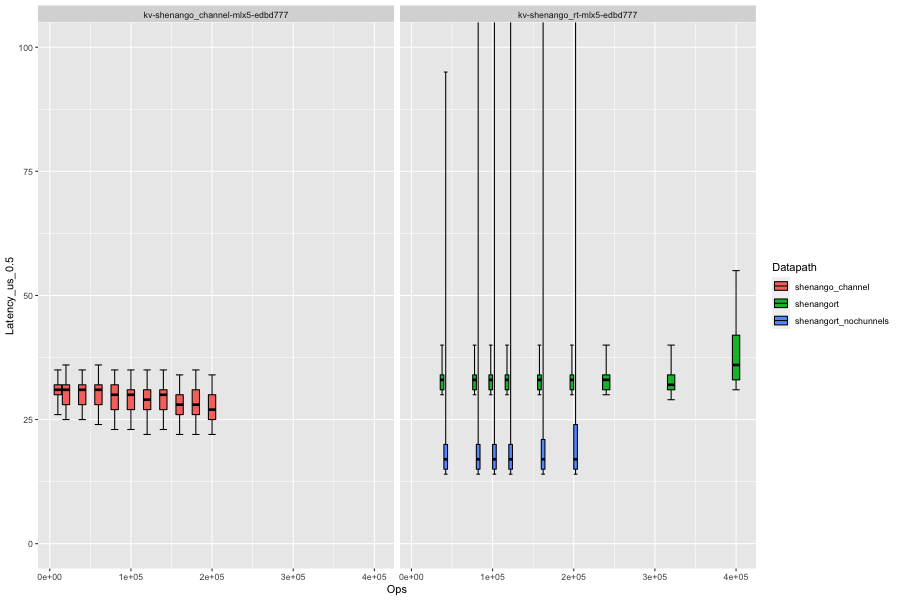

In [50]:
%%R -i df -w 900 -h 600

library(ggplot2)

ggplot(df, aes(x=Ops, fill=Datapath, group=interaction(Datapath,ShardType,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  facet_wrap(~Commit) +
  coord_cartesian(ylim=c(0, 100))

In [32]:
df.to_csv('kv-shenango-mlx5-edbd777.csv')

In [220]:
def do_norm(x):
    return pd.DataFrame({
        "Concurrency": x["Concurrency"],
        "ShardType": x["ShardType"],
        "NumShards": x["NumShards"],
        "Ops": x["Ops"],
        "Latency_us_0.05": x["Latency_us_0.05"] / x[x["Datapath"] == "dpdkmulti_nochunnels_conns"]["Latency_us_0.05"].iloc[0],
        "Latency_us_0.25": x["Latency_us_0.25"] / x[x["Datapath"] == "dpdkmulti_nochunnels_conns"]["Latency_us_0.25"].iloc[0],
        "Latency_us_0.5": x["Latency_us_0.5"] / x[x["Datapath"] == "dpdkmulti_nochunnels_conns"]["Latency_us_0.5"].iloc[0],
        "Latency_us_0.75": x["Latency_us_0.75"] / x[x["Datapath"] == "dpdkmulti_nochunnels_conns"]["Latency_us_0.75"].iloc[0],
        "Latency_us_0.95": x["Latency_us_0.95"] / x[x["Datapath"] == "dpdkmulti_nochunnels_conns"]["Latency_us_0.95"].iloc[0],
    })
    
norm = dpdk_client.groupby(
  ["Concurrency", "Poisson", "ShardType", "NumShards", "Ops"], group_keys=False
).apply(do_norm)
norm = norm.reset_index(drop=True)
norm

,Concurrency,ShardType,NumShards,Ops,Latency_us_0.05,Latency_us_0.25,Latency_us_0.5,Latency_us_0.75,Latency_us_0.95
0,workloadb-8,client,8,40000,0.583333,0.916667,0.916667,0.733333,0.705882
1,workloadb-8,client,8,80000,0.666667,0.846154,0.733333,0.750000,0.684211
2,workloadb-8,client,8,120000,0.727273,0.916667,0.733333,0.750000,0.631579
3,workloadb-8,client,8,160000,0.727273,0.916667,0.916667,0.687500,0.631579
4,workloadb-8,client,8,200000,0.636364,0.916667,0.733333,0.687500,0.600000
...,...,...,...,...,...,...,...,...,...
73,workloadb-8,client,8,640000,1.000000,1.000000,1.000000,1.000000,1.000000
74,workloadb-8,client,8,680000,1.000000,1.000000,1.000000,1.000000,1.000000
75,workloadb-8,client,8,720000,1.000000,1.000000,1.000000,1.000000,1.000000
76,workloadb-8,client,8,760000,1.000000,1.000000,1.000000,1.000000,1.000000


In [227]:
norm[norm["Ops"] == 800000]

,Concurrency,ShardType,NumShards,Ops,Latency_us_0.05,Latency_us_0.25,Latency_us_0.5,Latency_us_0.75,Latency_us_0.95
22,workloadb-8,client,8,800000,0.8,0.785714,0.647059,0.523810,0.483871
48,workloadb-8,client,8,800000,1.3,1.071429,1.058824,1.047619,1.096774
77,workloadb-8,client,8,800000,1.0,1.000000,1.000000,1.000000,1.000000


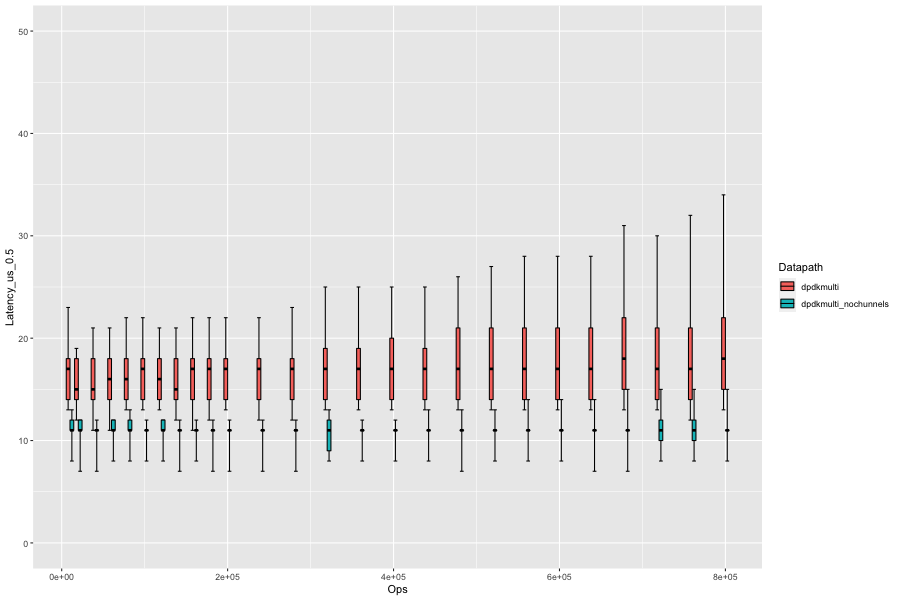

In [176]:
%%R -i dpdk_client -w 900 -h 600

library(ggplot2)

ggplot(dpdk_client, aes(x=Ops, fill=Datapath, group=interaction(Datapath,ShardType,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  coord_cartesian(ylim=c(0, 50))